In [1]:
import os
import numpy as np
import pandas as pd
from pandas import to_datetime
from matplotlib import pyplot as plt
import seaborn as sns
import itertools
import warnings
import datetime
from datetime import datetime
warnings.filterwarnings('ignore')

%matplotlib inline

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
import pmdarima as pm
from pmdarima.model_selection import train_test_split

In [2]:
# raw data 로딩 
raw_data = pd.read_csv(r'C:\\Users\\user\\Desktop\\intern.csv')
raw_data.head()

,Unnamed: 0,ORD_NO,H_YMD,O_YMD,PKG_GOODS_NO,PKG_GOODS_NM,GOODS_NO,GOODS_NM,STD_GSGR_NO_LEV1_NM,ORD_QTY,CANCEL_QTY,RET_QTY,REAL_ORD_QTY,RECVR_ROAD_BASE_ADDR,SALE_PRICE,DISCOUNT_AMT,FINAL_PRICE
0,0,202201095519105,2022-01-11 00:00:00,2022-01-09 12:26:10,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,충청북도 증평군 증평읍 송산로 11 (지평더웰아파트),6900,569.0,6331
1,1,202201105522898,2022-01-11 00:00:00,2022-01-10 10:35:49,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,서울특별시 강남구 논현로85길 52 (역삼동),6900,177.0,6723
2,2,202201115527172,2022-01-12 00:00:00,2022-01-11 11:38:32,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,"서울특별시 송파구 올림픽로4길 42 (잠실동, 우성아파트)",6900,221.0,6679
3,3,202201105523467,2022-01-12 00:00:00,2022-01-10 13:21:51,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,강원도 속초시 도리원길 11-14 (노학동),6900,128.0,6772
4,4,202201105522519,2022-01-11 00:00:00,2022-01-10 08:16:21,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,"경기도 용인시 수지구 동천로 64 (동천동, 동천마을동문굿모닝힐5차아파트)",6900,157.0,6743


In [13]:
raw = raw_data.loc[raw_data['GOODS_NO'] == 1712010310 ]
raw['H_YMD'] = pd.to_datetime(raw['H_YMD'])
resampled = raw.resample(rule='1D', on='H_YMD')   
resampled.sum()
df = resampled.sum()

In [15]:
df

,Unnamed: 0,ORD_NO,GOODS_NO,ORD_QTY,CANCEL_QTY,RET_QTY,REAL_ORD_QTY,SALE_PRICE,DISCOUNT_AMT,FINAL_PRICE
H_YMD,,,,,,,,,,
2020-01-01,10770303,17768282577159512,150656907280,93,7,0,86,607200,31439.0,575761
2020-01-02,19158928,31297471705099708,265361598050,174,7,1,167,1069500,48410.0,1021090
2020-01-03,18640474,30298555384029864,256801546500,165,9,0,156,1035000,19468.0,1015532
2020-01-04,20762089,33935018547130988,287617732080,189,14,0,175,1159200,30253.0,1128947
2020-01-05,0,0,0,0,0,0,0,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...
2022-05-27,19792805,21433756964726400,181473092860,122,1,0,121,826800,29765.0,797035
2022-05-28,17843301,19209500200698872,162640979450,115,3,0,112,741000,36854.0,704146
2022-05-29,0,0,0,0,0,0,0,0,0.0,0


In [3]:
# 자재코드와 자재명을 딕셔너리 형태로 만들기
GOODS_DIC = {1712010310 : '두메산나물비빔밥재료', 14375:	'옛날잡채(500g)', 3273:'채소계란찜(340g)', 13957:'셀프두부조림(600g)', 1901012353:'수제계란말이(350g)',
             13529:'메밀소바(2인분)', 1803010879:'고소한도토리묵무침(360g)', 2012014895:'한돈 제육볶음(700g)', 2204016772:'소고기유니짜장소스(1인분, 200g)', 
             1823:'숙주나물(300g)', 4092:'건표고버섯볶음', 14985:'양장피', 1808011751:'꼬막무침 (260g)', 1903012675:'순살코다리강정(180g)', 
             2010014667:'우삼겹숙주볶음(250g)', 1806011271:'열무비빔밥재료믹스(2인분)', 2103015231:'[심방골주부X더반찬] 시골 돼지짜글이(600g)', 
             2010014707:'고구마 품은 라자냐(450g)', 1805011121:'고사리나물볶음(150g)', 1909013359:'가정집 오징어불고기/셀프(380g)'
             }

In [4]:
GOODS_NO = GOODS_DIC.keys()
GOODS_NM = GOODS_DIC.values()

In [16]:
time_data = raw_data[['H_YMD', 'GOODS_NO', 'REAL_ORD_QTY']]
time_data = time_data.loc[time_data['GOODS_NO'] == 1712010310 ]
time_data = time_data.sort_values(by = 'H_YMD')
time_data.drop('GOODS_NO', axis=1, inplace=True)

time_data = time_data.groupby(['H_YMD'], as_index=False)
time_data = time_data.agg({
                           'REAL_ORD_QTY':['sum']
                        })
time_data.columns = [
                     'H_YMD', 'REAL_ORD_QTY',
                     ]

time_data

,H_YMD,REAL_ORD_QTY
0,2020-01-01 00:00:00,86
1,2020-01-02 00:00:00,167
2,2020-01-03 00:00:00,156
3,2020-01-04 00:00:00,175
4,2020-01-06 00:00:00,174
...,...,...
731,2022-05-26 00:00:00,140
732,2022-05-27 00:00:00,121
733,2022-05-28 00:00:00,112
734,2022-05-30 00:00:00,98


In [80]:
time_data = raw_data[['H_YMD', 'GOODS_NO', 'REAL_ORD_QTY']]
time_data = time_data.loc[time_data['GOODS_NO'] == 1712010310 ]
time_data = time_data.sort_values(by = 'H_YMD')
time_data.drop('GOODS_NO', axis=1, inplace=True)

time_data = time_data.groupby(['H_YMD'], as_index=False)
time_data = time_data.agg({
                           'REAL_ORD_QTY':['sum']
                        })
time_data.columns = [
                     'H_YMD', 'REAL_ORD_QTY',
                     ]

time_data

,H_YMD,REAL_ORD_QTY
0,2020-01-01 00:00:00,86
1,2020-01-02 00:00:00,167
2,2020-01-03 00:00:00,156
3,2020-01-04 00:00:00,175
4,2020-01-06 00:00:00,174
...,...,...
731,2022-05-26 00:00:00,140
732,2022-05-27 00:00:00,121
733,2022-05-28 00:00:00,112
734,2022-05-30 00:00:00,98


In [81]:
X_train = time_data[(time_data['H_YMD'] < '2022-05-01')]
#X_val = time_data[(time_data['H_YMD'] >= '2022-01-01') & (time_data['H_YMD'] < '2022-05-24')]
X_test = time_data[(time_data['H_YMD'] >= '2022-05-01')]

print('X_train: ', X_train.shape)
#print('X_val: ', X_val.shape)
print('X_test: ', X_test.shape)

X_train:  (710, 2)
X_test:  (26, 2)


In [82]:
X_train.set_index('H_YMD', inplace=True)

X_train

,REAL_ORD_QTY
H_YMD,
2020-01-01 00:00:00,86
2020-01-02 00:00:00,167
2020-01-03 00:00:00,156
2020-01-04 00:00:00,175
2020-01-06 00:00:00,174
...,...
2022-04-26 00:00:00,194
2022-04-27 00:00:00,204
2022-04-28 00:00:00,257


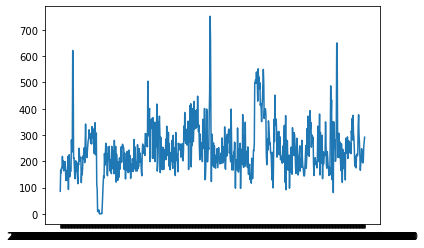

In [83]:
plt.plot(X_train)

<Figure size 432x288 with 0 Axes>

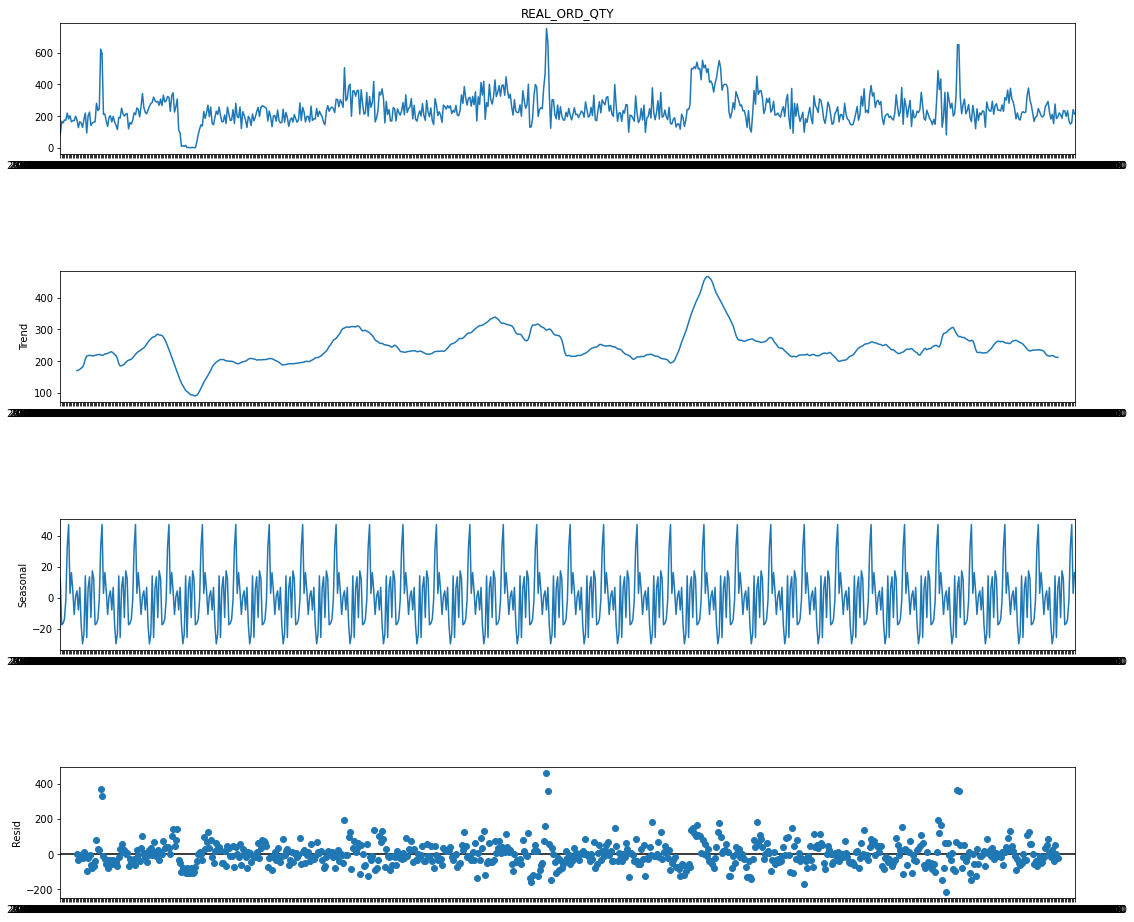

In [54]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(X_train['REAL_ORD_QTY'], model='additive', period=24)

fig = plt.figure()
fig = result.plot()
fig.set_size_inches(20,15)

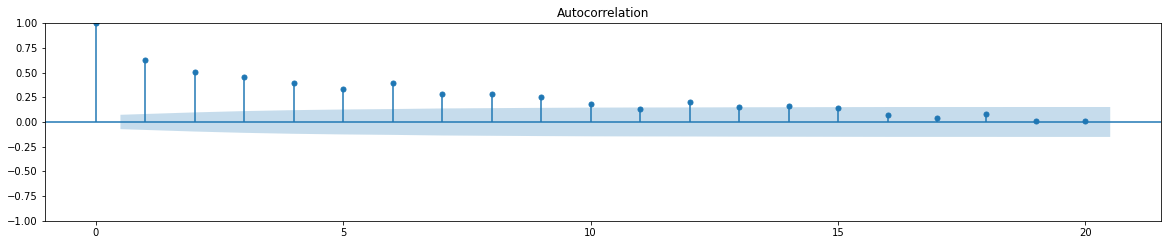

In [55]:
import statsmodels.api as sm

fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(X_train, lags=20, ax=ax1)

In [84]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(X_train)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values')

for k,v in result[4].items():
    print('\t%s: %.3f' %(k, v))

ADF Statistic: -4.988261
p-value: 0.000023
Critical Values
	1%: -3.440
	5%: -2.866
	10%: -2.569


In [59]:
X_train

,REAL_ORD_QTY
H_YMD,
2020-01-01 00:00:00,86
2020-01-02 00:00:00,167
2020-01-03 00:00:00,156
2020-01-04 00:00:00,175
2020-01-06 00:00:00,174
...,...
2022-05-18 00:00:00,170
2022-05-19 00:00:00,149
2022-05-20 00:00:00,158


In [85]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from pandas import datetime

#fit model
model = ARIMA(X_train, order=(1,0,2))
model_fit = model.fit()

c:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [87]:
X_test

,H_YMD,REAL_ORD_QTY
710,2022-05-02 00:00:00,226
711,2022-05-03 00:00:00,181
712,2022-05-04 00:00:00,211
713,2022-05-05 00:00:00,152
714,2022-05-06 00:00:00,276
715,2022-05-07 00:00:00,184
716,2022-05-09 00:00:00,194
717,2022-05-10 00:00:00,220
718,2022-05-11 00:00:00,210
719,2022-05-12 00:00:00,186


In [88]:
fcast = model_fit.forecast(31)
fcast = pd.Series(fcast)
fcast = fcast.rename("Arima")

fcast

c:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


710    266.295778
711    260.293418
712    258.621004
713    257.121250
714    255.776331
715    254.570262
716    253.488708
717    252.518815
718    251.649053
719    250.869086
720    250.169643
721    249.542410
722    248.979933
723    248.475527
724    248.023196
725    247.617563
726    247.253808
727    246.927608
728    246.635084
729    246.372761
730    246.137520
731    245.926565
732    245.737390
733    245.567744
734    245.415614
735    245.279189
736    245.156849
737    245.047139
738    244.948755
739    244.860529
740    244.781411
Name: Arima, dtype: float64